In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install --upgrade pandas

#!pip install talos
#!pip install statsmodels -U
#!pip install --upgrade pytest

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)


In [4]:
!ls "drive/My Drive/Colab Notebooks/data"

data_kaggle_proc.pickle		       news_getting_real.pickle
GoogleNews-vectors-negative300.bin.gz  news_proc_12_3_19.pickle


# Imports, loads , Train/test split and Optimum params
---

In [0]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [0]:
data = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

Labels asignadas a los tipos

In [7]:
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

bias - [1 0 0 0]
click - [0 1 0 0]
fake - [0 0 1 0]
truth - [0 0 0 1]


In [8]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1598
Max len title: 13


In [0]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [0]:
embed_mat = np.zeros((50000,300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

**Tran/valid/test split**

In [0]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [0]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [0]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [0]:
del data
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

## Optimum Params found with Bayesian Optimization

In [0]:
# Optimum params for LSTM network
params_lstm = {
    'lr': 0.25089565306979505,
    'momentum': 0.02947012104962393,
    'dropout': 0.11976231360733916
}


#Optimum params for CNN network
params_cnn = {
    'lr': 0.23993334664040306,
    'momentum': 0.30361299021107185,
    'dropout1': 0.10993063833594595,
    'dropout2': 0.1586041045258562,
    'filters1Title': 8,
    'denseTitle': 42,
    'filtersContent': 6,
    'denseContent': 34
}

In [0]:
#Some imports...
import tensorflow as tf
import os

from numpy.random import seed
from tensorflow import set_random_seed

# LSTM

In [0]:
seed(50)
set_random_seed(50)
k.backend.clear_session()

In [18]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False)(title_input)
#x = k.layers.Bidirectional(k.layers.LSTM(100))(inp)
#CudnnLSTM
x = k.layers.Bidirectional(k.layers.CuDNNLSTM(100))(inp)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False)(content_input)
#x2 = k.layers.Bidirectional(k.layers.LSTM(300))(inp2)
#CudnnLSTM
x2 = k.layers.Bidirectional(k.layers.CuDNNLSTM(300))(inp2)

#Merge
x = k.layers.concatenate([x, x2])


#Common part
x = k.layers.Dense(100, activation='relu')(x)
x = k.layers.Dropout(params_lstm['dropout'])(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)

out = k.layers.Dense(4, activation='softmax')(x)

#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

#model.compile(k.optimizers.SGD(), loss='categorical_crossentropy', metrics=['acc'])
model.compile(tf.train.MomentumOptimizer(learning_rate=params_lstm['lr'], 
                                         momentum=params_lstm['momentum']), 
                                         loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 13)           0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      (None, 1598)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embedding_1 (Embeddin

In [0]:
#Optimize TPU

# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.90.38.242:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 16769006676919830880)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6433662340739805021)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3821857194660653888)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

In [19]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64, epochs=30,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=1, min_delta = 0.1)], 
                 validation_data=(valid_fit, np.array(y_valid.tolist())))

Train on 94319 samples, validate on 40423 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
94319/94319 [==============================] - 682s 7ms/sample - loss: 1.1860 - acc: 0.4599 - val_loss: 1.0052 - val_acc: 0.5785
Epoch 2/30
94319/94319 [==============================] - 695s 7ms/sample - loss: 0.8728 - acc: 0.6420 - val_loss: 0.6935 - val_acc: 0.7226
Epoch 3/30
94319/94319 [==============================] - 687s 7ms/sample - loss: 0.7828 - acc: 0.6801 - val_loss: 1.0456 - val_acc: 0.5525
Epoch 4/30
94319/94319 [==============================] - 671s 7ms/sample - loss: 0.9279 - acc: 0.6143 - val_loss: 0.8676 - val_acc: 0.6432
Epoch 5/30
94319/94319 [==============================] - 671s 7ms/sample - loss: 0.8710 - acc: 0.6419 - val_loss: 0.8481 - val_acc: 0.6523


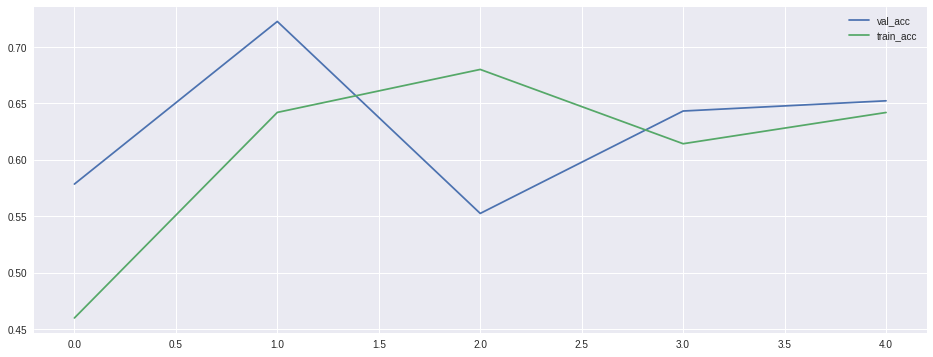

In [20]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

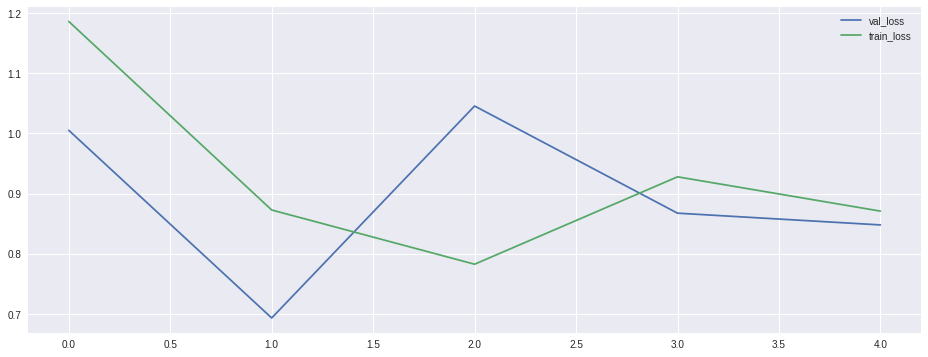

In [21]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [0]:
#For GPU
test_pred = model.predict(test_fit)

#For TPU
#tpu_batch = [test_fit[0][:-3], test_fit[1][:-3]]
#test_pred = tpu_model.predict(tpu_batch, batch_size=32*8)

In [26]:
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.46857845429199785

In [29]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.87      0.48      0.62     13497
           1       0.85      0.55      0.67     14960
           2       0.73      0.55      0.63     14430
           3       0.95      0.29      0.44     14860

   micro avg       0.83      0.47      0.60     57747
   macro avg       0.85      0.47      0.59     57747
weighted avg       0.85      0.47      0.59     57747
 samples avg       0.47      0.47      0.47     57747



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[[11748   429  1249    71]
 [ 6116  8258   532    54]
 [ 6002   364  7964   100]
 [ 8672   709  1183  4296]]


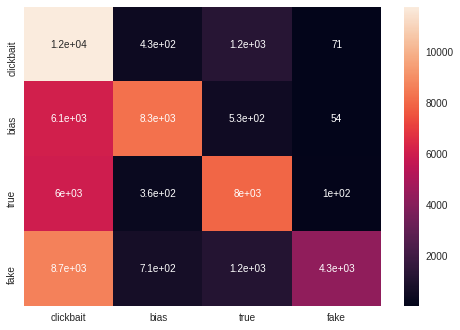

In [30]:
matrix = confusion_matrix(np.array(y_test.tolist()).argmax(axis=1), test_pred.round().argmax(axis=1))
print(matrix)

df_cm = pd.DataFrame(matrix, columns=['clickbait', 'bias', 'true', 'fake'], index=['clickbait', 'bias', 'true', 'fake'])
sns.heatmap(df_cm, annot=True)

In [0]:
LSTM_PATH = 'drive/My Drive/Colab Notebooks/weights/lstm.h5'

In [0]:
model.save(LSTM_PATH)

#Redes convolucionales

In [0]:
seed(50)
set_random_seed(50)
k.backend.clear_session()

In [18]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
#

x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(4, activation='softmax')(x)


#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

#model.compile(k.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='categorical_crossentropy', metrics=['acc'])
model.compile(k.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 13)           0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      (None, 1598)         0                                            
__________________________________________________________________________________________________
embed_title (Embedding)         (None, 13, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embed_content (Embedd

In [19]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.1)], validation_data=(valid_fit, np.array(y_valid.tolist())))

Train on 94319 samples, validate on 40423 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
94319/94319 [==============================] - 35s 369us/sample - loss: 0.8381 - acc: 0.7092 - val_loss: 0.6286 - val_acc: 0.7897
Epoch 2/20
94319/94319 [==============================] - 32s 336us/sample - loss: 0.5735 - acc: 0.8209 - val_loss: 0.5717 - val_acc: 0.8171
Epoch 3/20
94319/94319 [==============================] - 32s 343us/sample - loss: 0.4644 - acc: 0.8664 - val_loss: 0.5555 - val_acc: 0.8276
Epoch 4/20
94319/94319 [==============================] - 32s 335us/sample - loss: 0.3790 - acc: 0.8978 - val_loss: 0.5858 - val_acc: 0.8246


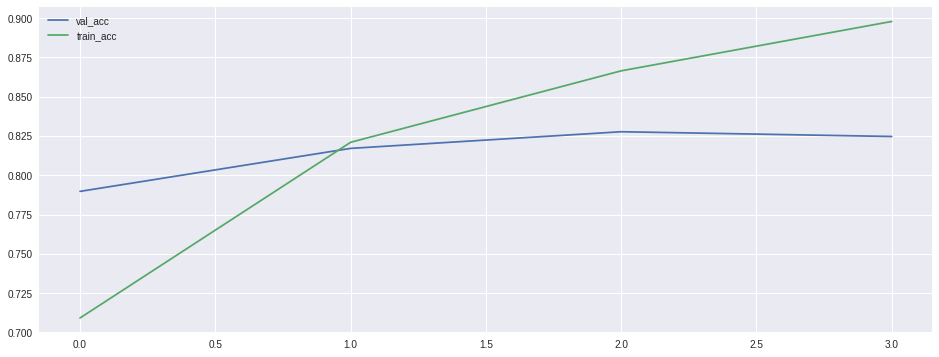

In [20]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

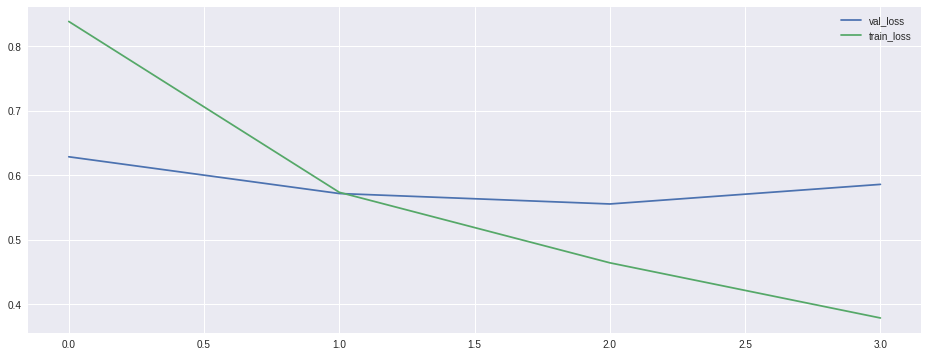

In [21]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [22]:
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.8028122673039292

In [23]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.86      0.78      0.82     13497
           1       0.91      0.85      0.88     14960
           2       0.88      0.81      0.85     14430
           3       0.77      0.77      0.77     14860

   micro avg       0.85      0.80      0.83     57747
   macro avg       0.86      0.80      0.83     57747
weighted avg       0.86      0.80      0.83     57747
 samples avg       0.80      0.80      0.80     57747



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[[11350   391   433  1323]
 [  999 12700   311   950]
 [ 1336   286 11722  1086]
 [ 1950   608   832 11470]]


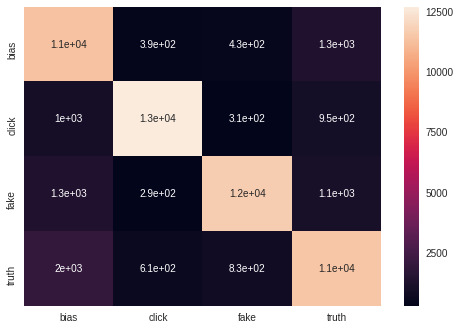

In [24]:
matrix = confusion_matrix(np.array(y_test.tolist()).argmax(axis=1), test_pred.round().argmax(axis=1))
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['bias', 'click', 'fake', 'truth'], index=['bias', 'click', 'fake', 'truth'])
sns.heatmap(df_cm, annot=True)

In [0]:
CONV_PATH = 'drive/My Drive/Colab Notebooks/weights/conv.h5'
model.save(CONV_PATH)

# Buscar hiperparámetros óptimos para la CNN (GridSearch)
**Nota:** *Ahora se usa Optimizacion Bayesiana. Este código es de una versión previa*

In [0]:
import talos as ta

Using TensorFlow backend.


In [0]:
p = {
    'optimizer' : [k.optimizers.Nadam, k.optimizers.Adam, k.optimizers.Adagrad],
    'lr' : (0.001, 0.1, 0.2, 0.3),
}

In [0]:
def cnn_model(x_train, y_train, x_val, y_val, params):
    #input_title
    title_input = k.layers.Input(shape=(len_title,), name='title_input')
    inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False, name='embed_title')(title_input)

    x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
    x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
    x = k.layers.Flatten()(x)
    x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

    #input_content
    content_input = k.layers.Input(shape=(len_content,), name='content_input')
    inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False, name='embed_content')(content_input)
    x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

    #Added
    x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
    #

    x2 = k.layers.Flatten()(x2)
    x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


    #Merge
    x = k.layers.concatenate([x, x2])

    #Common part
    x = k.layers.Dense(50, activation='relu')(x)
    x = k.layers.Dropout(0.2)(x)
    x = k.layers.Dense(50, activation='relu')(x)
    x = k.layers.Dropout(0.2)(x)
    out = k.layers.Dense(4, activation='softmax')(x)


    #Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    model.compile(params['optimizer'](lr=params['lr']), loss='categorical_crossentropy', metrics=['acc'])
    
    out = model.fit(x=x_train, y=y_train, batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.1)], 
                    validation_data=(x_val, y_val))
    
    return out, model

In [0]:
t = ta.Scan(x = train_fit, 
        y=np.asarray(y_train.tolist()), 
        x_val = valid_fit, 
        y_val = np.array(y_valid.tolist()), 
        params = p, 
        model=cnn_model,
        clear_tf_session=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 94319 samples, validate on 40423 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
94319/94319 [==============================] - 93s 989us/sample - loss: 0.8582 - acc: 0.7232 - val_loss: 0.7067 - val_acc: 0.7766
Epoch 2/20
94319/94319 [==============================] - 92s 976us/sample - loss: 0.6154 - acc: 0.8284 - val_loss: 0.6505 - val_acc: 0.8083
Epoch 3/20
94319/94319 [==============================] - 92s 975us/sample - loss: 0.5234 - acc: 0.8726 - val_loss: 0.6268 - val_acc: 0.8221
Epoch 4/20
94319/94319 [==============================] - 92s 975us/sample - loss: 0.4389 - acc: 0.9030 - val_loss: 0.6531 - val_acc: 0.8264


 33%|███▎      | 1/3 [06:14<12:28, 374.15s/it]

Train on 94319 samples, validate on 40423 samples
Epoch 1/20
94319/94319 [==============================] - 93s 989us/sample - loss: 0.8565 - acc: 0.7195 - val_loss: 0.6680 - val_acc: 0.7951
Epoch 2/20
94319/94319 [==============================] - 93s 983us/sample - loss: 0.6070 - acc: 0.8281 - val_loss: 0.6237 - val_acc: 0.8203
Epoch 3/20
94319/94319 [==============================] - 92s 973us/sample - loss: 0.5242 - acc: 0.8675 - val_loss: 0.6264 - val_acc: 0.8229
Epoch 4/20
94319/94319 [==============================] - 91s 969us/sample - loss: 0.4439 - acc: 0.8993 - val_loss: 0.6686 - val_acc: 0.8243


 67%|██████▋   | 2/3 [12:25<06:13, 373.44s/it]

Train on 94319 samples, validate on 40423 samples
Epoch 1/20
94319/94319 [==============================] - 93s 990us/sample - loss: 1.3882 - acc: 0.5843 - val_loss: 1.0340 - val_acc: 0.6761
Epoch 2/20
94319/94319 [==============================] - 92s 977us/sample - loss: 0.9704 - acc: 0.6942 - val_loss: 0.9034 - val_acc: 0.7078
Epoch 3/20
94319/94319 [==============================] - 92s 977us/sample - loss: 0.8659 - acc: 0.7277 - val_loss: 0.8483 - val_acc: 0.7206
Epoch 4/20
94319/94319 [==============================] - 92s 976us/sample - loss: 0.8003 - acc: 0.7502 - val_loss: 0.8112 - val_acc: 0.7337
Epoch 5/20
94319/94319 [==============================] - 93s 981us/sample - loss: 0.7532 - acc: 0.7641 - val_loss: 0.7812 - val_acc: 0.7395
Epoch 6/20
94319/94319 [==============================] - 92s 980us/sample - loss: 0.7133 - acc: 0.7794 - val_loss: 0.7633 - val_acc: 0.7466
Epoch 7/20
94319/94319 [==============================] - 93s 982us/sample - loss: 0.6784 - acc: 0.7917 

100%|██████████| 3/3 [24:50<00:00, 484.78s/it]


In [0]:
t.data

,round_epochs,loss,acc,val_loss,val_acc,optimizer,lr
0,4,0.43889144828694954,0.90301,0.626791067865452,0.82643545,<class 'tensorflow.python.keras.optimizers.Nad...,0.001
1,4,0.44387613860525615,0.89932036,0.623676198536764,0.82425845,<class 'tensorflow.python.keras.optimizers.Adam'>,0.001
2,8,0.6476933200893289,0.8030726,0.7316609426794308,0.754323,<class 'tensorflow.python.keras.optimizers.Ada...,0.001


In [0]:
t.data.loc[0]

round_epochs                                                    4
loss                                          0.43889144828694954
acc                                                       0.90301
val_loss                                        0.626791067865452
val_acc                                                0.82643545
optimizer       <class 'tensorflow.python.keras.optimizers.Nad...
lr                                                          0.001
Name: 0, dtype: object